# Logistic regression

In this notebook, heavily inspired by [PyMC3's Logistic Regression examples](https://docs.pymc.io/en/stable/pymc-examples/examples/generalized_linear_models/GLM-logistic.html) we model the probability of one making more thean $50,000 using the [Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult). We use `aeppl` as a modeling language and `aehmc`'s NUTS algorithm to sample from the posterior distribution.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

import aesara
import aesara.tensor as at
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesOpt, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
import aehmc.nuts as nuts
from aehmc.utils import RaveledParamsMap

%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
NUM_SAMPLES = 1_000
BURNIN = 100

## Load an prepare the data

In [3]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)[:2000]

In [4]:
income = 1 * (raw_data['income'] == " >50K")

data = raw_data[["age", "educ", "hours"]]
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

Y_val = income.values
X_val = data[["age", "age2","educ", "hours"]].values

<ipython-input-4-17906e68a4f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age"] = data["age"] / 10.0
<ipython-input-4-17906e68a4f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age2"] = np.square(data["age"])
<ipython-input-4-17906e68a4f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [5]:
data.income.value_counts()

0    1501
1     499
Name: income, dtype: int64

### PyMC3 model implementation

In [109]:
with pm.Model() as pymc3_model:
    intercept = pm.Normal('intercept', 0, 1)
    age = pm.Normal('age', 0, 1)
    age2 = pm.Normal('age2', 0, 1)
    educ = pm.Normal('educ', 0, 1)
    hours = pm.Normal('hours', 0, 1)
    theta = pm.math.sigmoid(intercept + age * data['age'] + age2 * data['age2'] + educ * data['educ'] + hours * data['hours'])
    y = pm.Bernoulli('y', theta, observed=data['income'])


    step = pm.step_methods.NUTS([intercept, age, age2, educ, hours])
    trace = pm.sample(NUM_SAMPLES, tune=2000, step=step, init="adapt_diag", chains=1)

<ipython-input-109-01cea75f2dbc>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(NUM_SAMPLES, tune=2000, step=step, init="adapt_diag", chains=1)
Sequential sampling (1 chains in 1 job)
NUTS: [hours, educ, age2, age, intercept]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'age2'}>,
        <AxesSubplot:title={'center':'age2'}>],
       [<AxesSubplot:title={'center':'educ'}>,
        <AxesSubplot:title={'center':'educ'}>],
       [<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'hours'}>]], dtype=object)

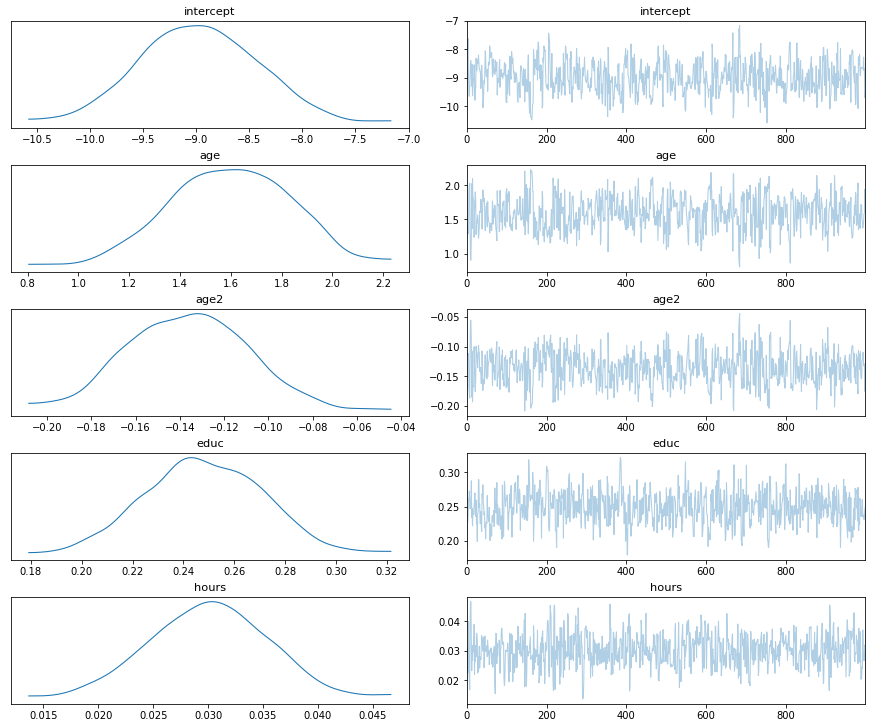

In [110]:
az.plot_trace(trace)

In [111]:
trace.get_sampler_stats('step_size_bar')[-1]

0.07744667906878504

In [112]:
pymc3_covariance = step.potential._var
pymc3_covariance

array([2.52378284e-05, 7.01888832e-04, 8.41051725e-04, 6.58887846e-02,
       2.37143882e-01])

In [113]:
step.vars

[hours ~ Normal,
 educ ~ Normal,
 age2 ~ Normal,
 age ~ Normal,
 intercept ~ Normal]

In [114]:
pymc3_covariance[::-1]

array([2.37143882e-01, 6.58887846e-02, 8.41051725e-04, 7.01888832e-04,
       2.52378284e-05])

In [89]:
step.vars[::-1]

[intercept ~ Normal,
 age ~ Normal,
 age2 ~ Normal,
 educ ~ Normal,
 hours ~ Normal]

### Aeppl model implementation

In [10]:
X_at = at.as_tensor(X_val)
Y_at = at.as_tensor(Y_val)

A_rv = at.random.normal(0, 1, name='alpha')
B_rv = at.random.normal(0, 1, size=(4,), name='beta')
P_rv = at.sigmoid(A_rv + at.dot(X_at, B_rv))
Y_rv = at.random.bernoulli(P_rv)

rp_map = RaveledParamsMap((A_rv, B_rv))

def logistic_logprob(q):
    unraveled_params = rp_map.unravel_params(q)
    A_vv = unraveled_params[A_rv]
    B_vv = unraveled_params[B_rv]
    logprob = joint_logprob({Y_rv: Y_at, A_rv: A_vv, B_rv: B_vv})
    return logprob

### Sampling with aehmc's NUTS algorithm

The difference probably stems from the use of a flat prior on the intercept.

In [11]:
q = at.vector("q")
potential_energy = -logistic_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

step_size = at.scalar("step_size")
inverse_mass_matrix = at.vector("inverse_mass_matrix")
num_integration_steps = at.scalar("num_integration_steps", dtype="int32")

srng = RandomStream(seed=0)
kernel = nuts.kernel(srng, logistic_logprob, inverse_mass_matrix)

num_samples = at.scalar('num_samples', dtype='int32')
trajectory, updates = aesara.scan(
    fn=kernel,
    outputs_info=[
        {"initial": q},
        {"initial": potential_energy},
        {"initial": potential_energy_grad},
        None,
        None,
        None,
    ],
    non_sequences=step_size,
    n_steps=num_samples,
)
trajectory_generator = aesara.function(
    (q, step_size, inverse_mass_matrix, num_samples),
    trajectory,
    updates=updates,
    mode='FAST_RUN'
)

WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  Fil

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (Shape_i{0}.0,), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError(f"Le

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

ERROR (aesara.graph.opt): Optimization failure due to: random_make_inplace
ERROR (aesara.graph.opt): node: normal_rv{0, (0, 0), floatX, False}(<RandomGeneratorType>, <TensorType(int64, vector)>, TensorConstant{11}, TensorConstant{0}, TensorConstant{1})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/graph/opt.py", line 2025, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/graph/opt.py", line 1187, in transform
    return self.fn(*args, **kwargs)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/opt.py", line 49, in random_make_inplace
    return new_op.make_node(*node.inputs).outputs
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 349, in make_node
    bcast = self.compute_bcast(dist_params

In [ ]:
%%time
initial_position = np.array([-9., 1.6, -0.125, 0.25, 0.02])
inverse_mass_matrix = np.array([2.37143882e-01, 6.58887846e-02, 8.41051725e-04, 7.01888832e-04, 2.52378284e-05])
#np.array([3.95207320e-01, 7.44079553e-02, 9.21538715e-04, 5.54702894e-04, 2.36889254e-05])
position, *_ = trajectory_generator(initial_position, 0.08, inverse_mass_matrix, 1_000)  #0.07

In [ ]:
import matplotlib.pyplot as plt

plt.hist(_[-3]);

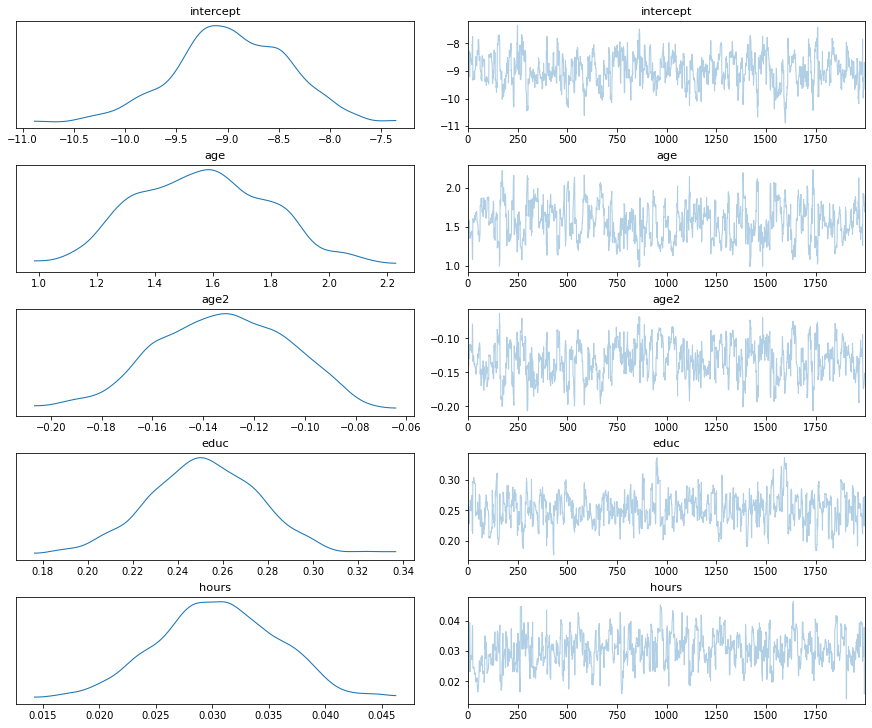

In [106]:
import arviz as az

BURNIN = 0
aehmc_trace = az.from_dict(
    posterior={
        "intercept": position[BURNIN:, 0],
        "age": position[BURNIN:, 1],
        "age2": position[BURNIN:, 2],
        "educ": position[BURNIN:, 3],
        "hours": position[BURNIN:, 4],
    }
)
az.plot_trace(aehmc_trace);